# Physics 305 Demo Notebook 1: Simulating Stochastic Processes

## Part 1: Simulating Brownian Motion

Brownian Motion: $B(t)$

Increment of the particle:

$dx = \mu(t)dt + \sigma(t) dB(t)$,

where $\mu(t)$ is the time-dependent drift coefficient and $\sigma^2(t) = 2D$, where $D$ is the diffusion coefficent.

Setting $\mu(t) = 0$ for simplicity (no drift), we have:

$dx = \sigma(t) dB(t)$

The increment has the Gaussian (normal) distribution $N(0, \sigma^2 dt)$, where $N(a,b)$ is the normal distribution with mean $a$ and variance $b$.

Setting $\sigma(t)=1$ and the initial position $x_0=0$ for simplicity, we get the *standard Brownian motion*. Note that this corresponds to $D = 1/2$.

We can numerically simulate Brownian motion by generating random numbers drawn from a normal distribution and getting their cumulative sum.

In [1]:
# import libraries
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Set random seed
np.random.seed(seed=17)

# Set parameters
n = int(1e6)  # no. of timesteps
dt = 1.  # size of time step
sd = np.sqrt(dt) # standard deviation

print("Number of timesteps n: %d" % n)
print("Time step dt: %.4f" % dt)
print("Standard Deviation sd: %.4f" % sd)

Number of timesteps n: 1000000
Time step dt: 1.0000
Standard Deviation sd: 1.0000


In [3]:
# Generate random numbers from Gaussian distribution centered at 0 and standard deviation sd
rnd = norm.rvs(size = n, scale = sd)

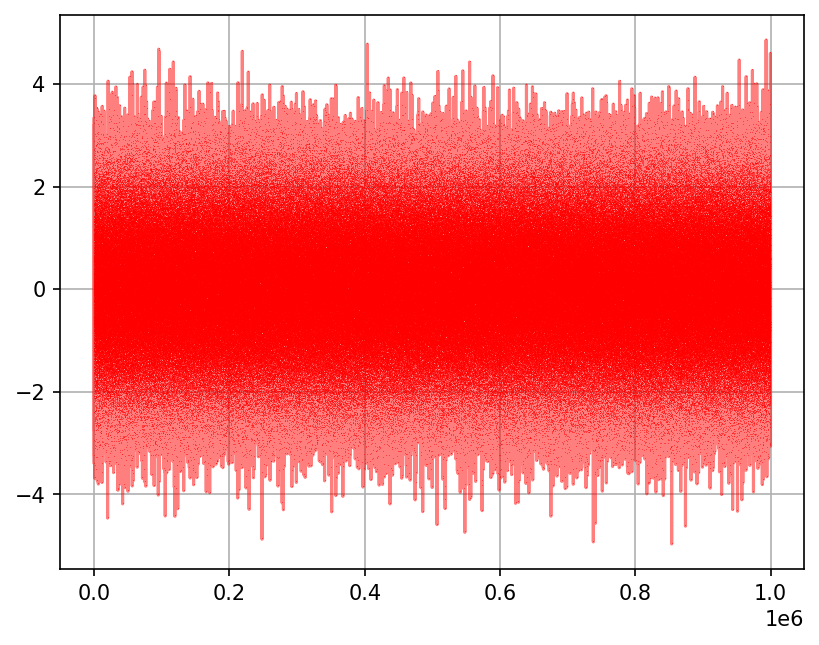

In [18]:
plt.figure(dpi = 150)
plt.grid()
plt.plot(rnd, 'r,-', alpha = 0.5)
plt.show()

In [4]:
len(rnd)

1000000

In [5]:
np.min(rnd), np.max(rnd)

(-4.964134609007479, 4.857362284140047)

In [10]:
(np.min(rnd), np.max(rnd))/sd

array([-4.96413461,  4.85736228])

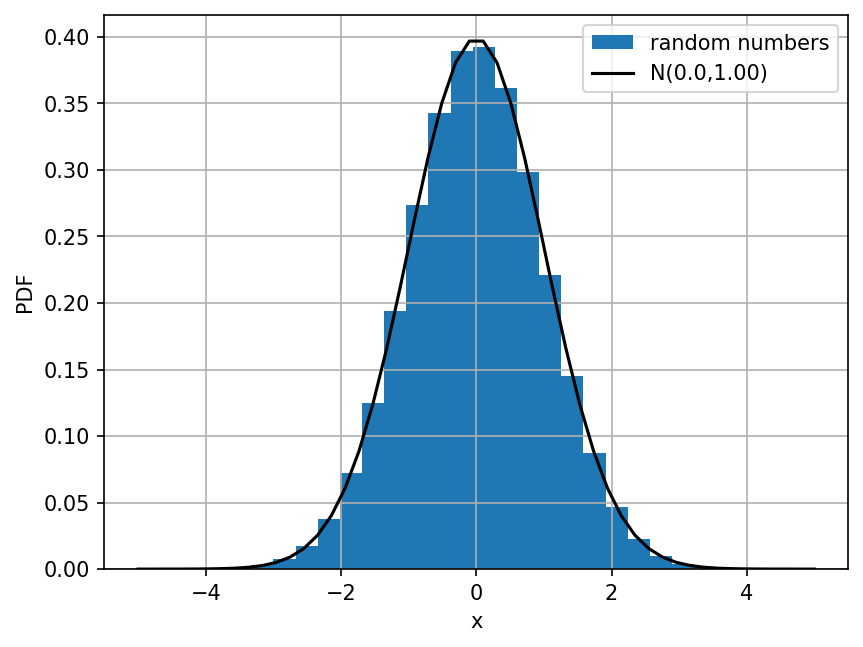

In [31]:
# Generate Gaussian distribution
xx = np.linspace(-5, 5)*sd # gridded points from -5 to 5 in units of sd
xx_mean = 0.
xx_sd = sd
yy = norm.pdf(xx, xx_mean, xx_sd)

# Plot histogram of random numbers
n_bins = 30

plt.figure(dpi = 150)
plt.grid()
plt.hist(rnd, density=True, bins=n_bins, label="random numbers")

# Overlay normal distribution
plt.plot(xx, yy, 'k-', label="N(%.1f,%.2f)" % (xx_mean, xx_sd))
plt.ylabel("PDF")
plt.xlabel("x")
plt.legend(loc="best")

In [12]:
# Get cumulative sum of the elements of the array of random numbers
x = np.cumsum(rnd)

In [13]:
rnd[0:10], x[0:10]

(array([ 0.27626589, -1.85462808,  0.62390111,  1.14531129,  1.03719047,
         1.88663893, -0.11169829, -0.36210134,  0.14867505, -0.43778315]),
 array([ 0.27626589, -1.57836219, -0.95446108,  0.19085021,  1.22804068,
         3.11467961,  3.00298132,  2.64087998,  2.78955503,  2.35177187]))

Text(0, 0.5, 'x')

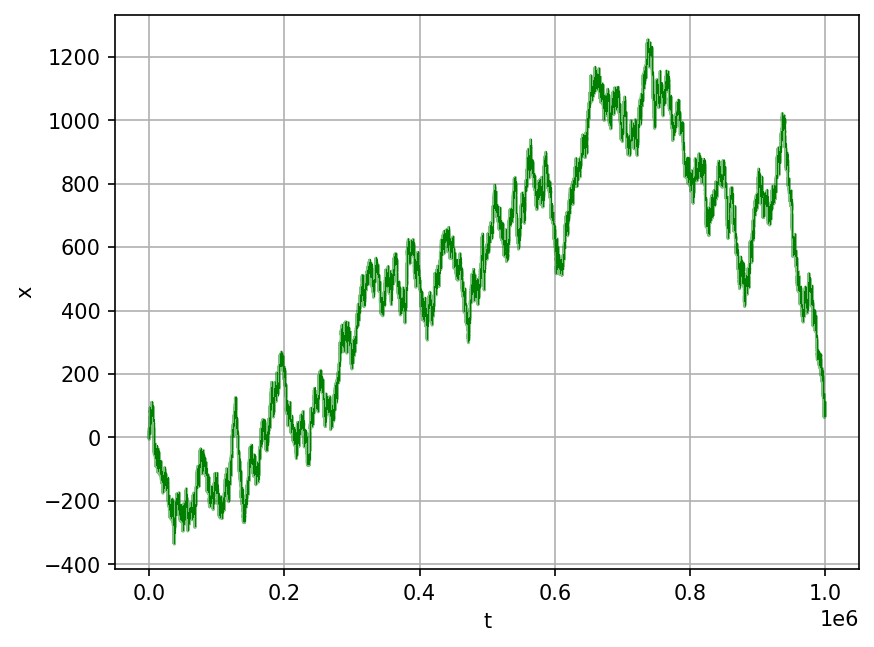

In [17]:
# Plot the Brownian motion
t = dt*np.arange(n)
plt.figure(dpi = 150)
plt.grid()
plt.plot(t, x, 'g,-', alpha = 0.5)
plt.xlabel("t")
plt.ylabel("x")

## Part 2: Simulating Fractional Brownian Motion

Fractional Brownian Motion: $B^H(t)$

Here, $H$ is the Hurst parameter. The different regimes depend on the value of $H$:
- 0 < H < 1/2: subdiffusion
- 1/2 < H < 1: superdiffusion
- H = 1/2: normal diffusion (Brownian motion)

We can numerically simulate fractional Brownian motion using the Wood-Chan or circulant method discussed in Georgiy Shevchenko's lecture notes from the 7th Jagna International Workshop: "Fractional Motion in a Nutshell" - https://arxiv.org/pdf/1406.1956.pdf (Section 6). The following code is translated from the original Matlab code.

For this course, we can consider the above supplementary reading.

In [19]:
# import libraries
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline

In [20]:
# define functions
def fbc(n,G):
    return ((n+1)**G + np.abs(n-1)**G - 2*n**G)/2.

def lambda_func(H,N):
    M = 2*N - 2
    C = np.zeros(M)
    G = 2*H
    for i in np.arange(N):
        C[i] = fbc(i,G) # fill in first N out of M values of C (i=0 to N-1)
    C[N:] = C[1:N-1][::-1]
    return np.real(np.fft.fft(C))**0.5

In [21]:
# set process parameters
q = 11
N = 2**q + 1
M = 2*N - 2
delta = 0.002
print("q: %d, N: %d, M: %d" % (q, N, M))

q: 11, N: 2049, M: 4096


In [22]:
# initialize
noise = np.random.normal(size=(M))
fGnsamples = np.zeros((5,N))

# generate fractional Gaussian noise samples
for i in np.arange(5):
    H = 0.2*(i+1) - 0.1
    lambda_res = lambda_func(H,N)
    a = np.fft.ifft(noise)*lambda_res
    b = np.real(np.fft.fft(a))
    fGnsamples[i,0] = 15-3*(i+1)            # apply offset in starting value for visualization
    fGnsamples[i,1:N] = delta**H*b[0:N-1]

# take cumulative sums to get the fractional Brownian motion samples
fBmsamples = np.transpose(np.cumsum(fGnsamples,axis=1)) # cumulative sum over each row

In [23]:
np.shape(fBmsamples)

(2049, 5)

In [24]:
# get values of H
Hval = (np.arange(5) + 1)*0.2 - 0.1
print(Hval)

[0.1 0.3 0.5 0.7 0.9]


Text(0, 0.5, 'x')

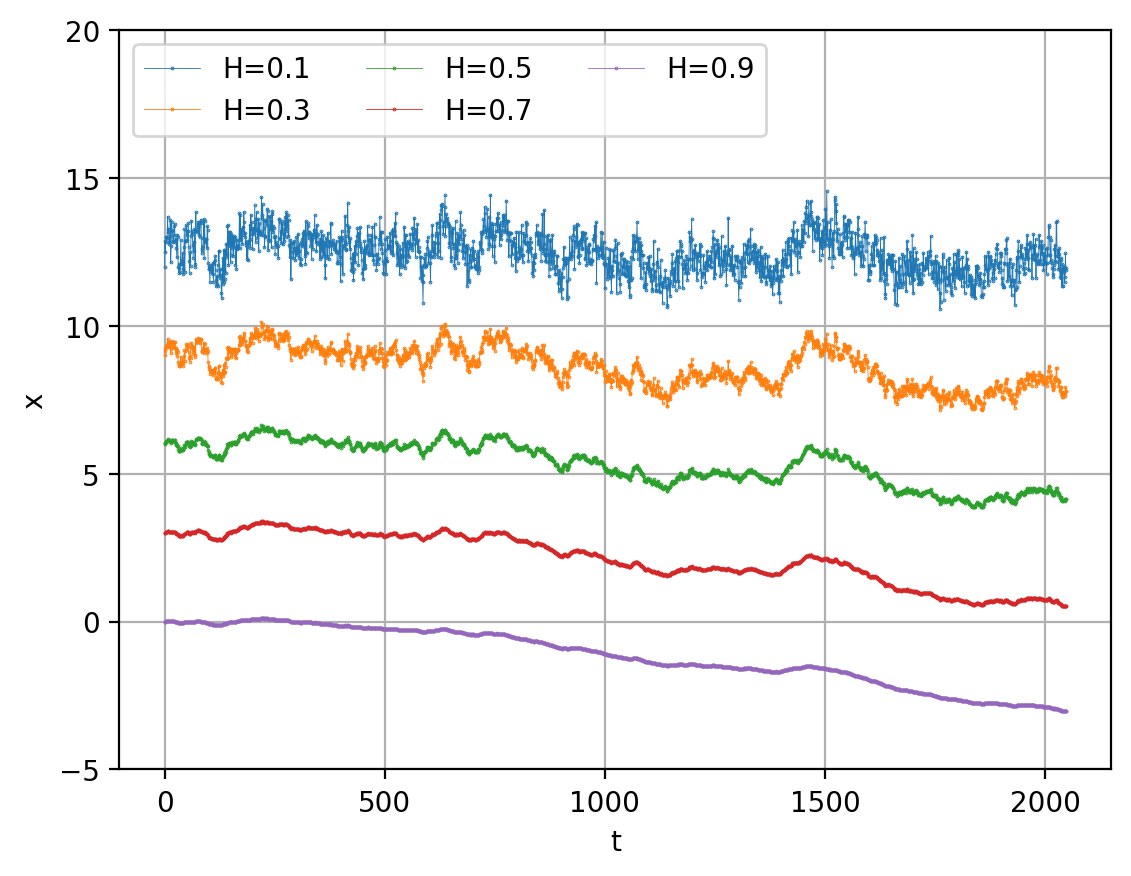

In [35]:
# plot fractional Brownian motion samples
plt.figure(dpi = 200)
plt.grid()
for i in np.arange(len(Hval)):
  plt.plot(fBmsamples[:,i], label="H=%.1f" % Hval[i], marker = '.', ls = '-', lw = 0.3, ms = 0.7)
plt.ylim(-5, 20)
plt.legend(loc="upper left", ncol=3)
plt.xlabel("t")
plt.ylabel("x")